In [1]:
!pip install opencv-python matplotlib numpy tensorflow kaggle

INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
ERROR: Could not find a version that satisfies the requirement keras<2.16,>=2.15.0 (from tensorflow) (from versions: none)
ERROR: No matching distribution found for keras<2.16,>=2.15.0


In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import random
import os
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image

2024-05-28 11:44:50.267063: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 11:44:50.267164: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 11:44:50.394743: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


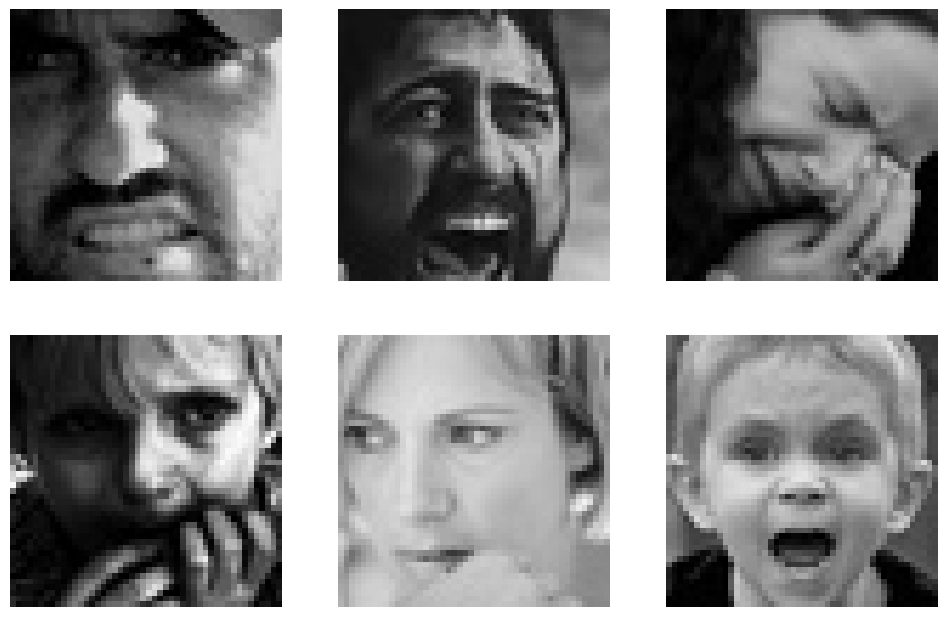

In [3]:
images = glob("/kaggle/input/fer2013/train/**/**")

plt.figure(figsize=(12,12))
for i in range(6):
    image = random.choice(images)
    plt.subplot(3, 3, i+1)
    plt.imshow(cv2.imread(image))
    plt.axis('off')

In [4]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator(horizontal_flip=True)

train_generator = datagen_train.flow_from_directory("/kaggle/input/fer2013/train",
                target_size = (img_size, img_size), color_mode = "grayscale", batch_size = batch_size, class_mode = "categorical", shuffle= True)

datagen_validation = ImageDataGenerator()

validation_generator = datagen_validation.flow_from_directory("/kaggle/input/fer2013/test",
                target_size = (img_size, img_size), color_mode = "grayscale", batch_size = batch_size, class_mode = "categorical", shuffle= True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [5]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters = filters, kernel_size = kernel_size, padding = "same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling2D(pool_size = (2,2))(x)
    x = Dropout(0.25)(x)
    return x

In [6]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.25)(x)
    return x

In [7]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs, 64, (3,3))
    conv_2 = Convolution(inputs, 128, (5,5))
    conv_3 = Convolution(inputs, 512, (3,3))
    conv_4 = Convolution(inputs, 512, (3,3))


    flatten = Flatten()(conv_4)
    dense_1 = Dense_f(flatten, 256)
    dense_2 = Dense_f(dense_1, 512)
    output = Dense(7, activation = 'softmax')(dense_2)
    model = Model(inputs=inputs, outputs=output)
    
    opt = Adam(learning_rate = 0.0005)

    model.compile(
        loss = ['categorical_crossentropy'],
        optimizer = 'adam',
        metrics = ['accuracy']
    )
    return model

In [8]:
model = model_fer((48,48,1))
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 48, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 48, 48, 512)    │         5,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 48, 48, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 48, 48, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 24, 24, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 24, 24, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 294912)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    75,497,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,643,143 (288.56 MB)

 Trainable params: 75,640,583 (288.55 MB)

 Non-trainable params: 2,560 (10.00 KB)

In [9]:
epochs = 50
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps = validation_generator.n//validation_generator.batch_size
checkpoint = ModelCheckpoint(
    'model_weights.weights.h5',
    monitor = 'val_accuracy',
    save_weights_only = True,
    mode = 'max',
    verbose = 1
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.1,
    patience = 2,
    min_lr = 0.001
)
callbacks = [checkpoint]

In [10]:
history = model.fit(
    x = train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = validation_steps,
    callbacks = callbacks
                    )

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  1/448 ━━━━━━━━━━━━━━━━━━━━ 1:33:16 13s/step - accuracy: 0.2031 - loss: 2.2047

I0000 00:00:1716896760.447345     118 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.2973 - loss: 1.8690
Epoch 1: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 119s 239ms/step - accuracy: 0.2974 - loss: 1.8686 - val_accuracy: 0.2314 - val_loss: 1.8903
Epoch 2/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.3438 - loss: 1.4959

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.3438 - loss: 1.4959 - val_accuracy: 0.1000 - val_loss: 2.0984
Epoch 3/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4213 - loss: 1.4949
Epoch 3: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 32s 70ms/step - accuracy: 0.4214 - loss: 1.4948 - val_accuracy: 0.2687 - val_loss: 1.9198
Epoch 4/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.4219 - loss: 1.4828
Epoch 4: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4219 - loss: 1.4828 - val_accuracy: 0.6000 - val_loss: 1.6543
Epoch 5/50
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4740 - loss: 1.3656
Epoch 5: saving model to model_weights.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 29s 65ms/step - accuracy: 0.4740 - loss: 1.3656 - val_accuracy: 0.3715 - val_loss: 1.5922
Epoch 6/50
  1/448 ━━━━━━━━━━━━━━━━━━━━ 13s 29ms/step - accuracy

In [11]:
model.evaluate(validation_generator)

113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.4744 - loss: 2.0306


[1.952543020248413, 0.4800780117511749]

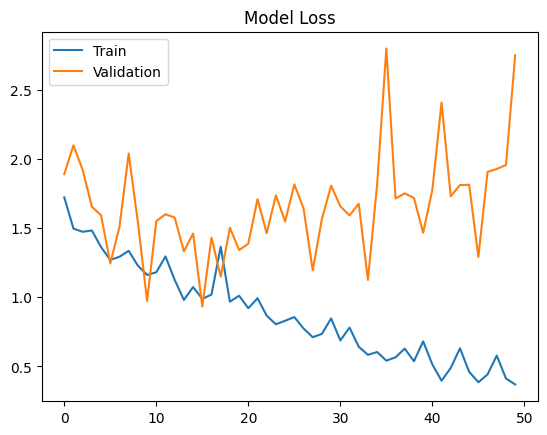

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

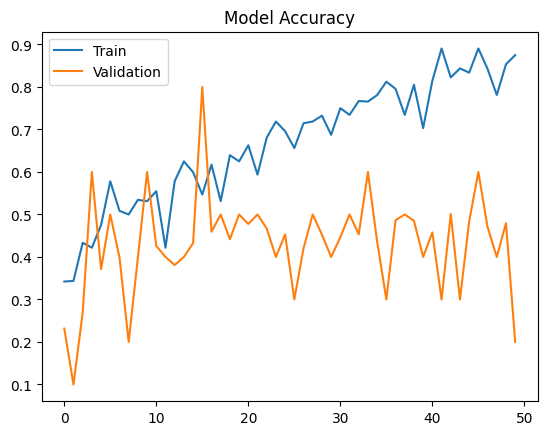

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

In [14]:
model_json = model.to_json()
with open ('model_a.json', 'w') as f:
    f.write(model_json)